In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from LSTM import *

%load_ext autoreload
%autoreload 2

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [3]:
print(f"Dimensions: {df_train.shape}, {df_test.shape}")
print("\nTotal NA values:", df_train.isna().sum().sum())

Dimensions: (7352, 563), (2947, 563)

Total NA values: 0


In [4]:
activities = df_train["Activity"].unique()
map_labels = {i: k for k, i in dict(enumerate(activities)).items()}

df_train["Activity"] = df_train["Activity"].apply(lambda x : map_labels[x])
df_test["Activity"] = df_test["Activity"].apply(lambda x : map_labels[x])

print(map_labels)

# Subject columns indicating which subject out of the thirty, not useful for prediction
df_train.drop("subject", axis = 1, inplace = True)
df_test.drop("subject", axis = 1, inplace = True)

{'STANDING': 0, 'SITTING': 1, 'LAYING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}


In [12]:
def create_time_sequences(X, y, sequence_length):
    n_samples = X.shape[0]
    X_seq = [X[i:i + sequence_length] for i in range(n_samples - sequence_length)]
    y_seq = [y[i + sequence_length] for i in range(n_samples - sequence_length)]
    return np.array(X_seq), np.array(y_seq)

X_train_full = df_train.drop(columns="Activity").values
y_train_full = df_train["Activity"].values
X_test_full = df_test.drop(columns="Activity").values
y_test_full = df_test["Activity"].values

sequence_length = 10
X_train, y_train = create_time_sequences(X_train_full, y_train_full, sequence_length)
X_test, y_test = create_time_sequences(X_test_full, y_test_full, sequence_length)

print(X_train.shape, X_test.shape)

(7342, 10, 561) (2937, 10, 561)


In [6]:
num_features = X_train.shape[-1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'mps'

model = ActivityLSTM(
    input_shape=num_features,
    num_classes=len(map_labels),
    dropout=0.3
).to(device)

In [7]:
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = ActivityDataset(X_train, y_train)
test_dataset = ActivityDataset(X_test, y_test)

val_size = 0.5
X_val, X_final_test, y_val, y_final_test = train_test_split(
  X_test, y_test, test_size=val_size, random_state=42, stratify=y_test
)

val_dataset = ActivityDataset(X_val, y_val)
final_test_dataset = ActivityDataset(X_final_test, y_final_test)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = ActivityLSTM(input_shape=num_features, num_classes=len(map_labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [9]:
print(f'Using device: {device}')
num_epochs = 100

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Using device: cpu
Epoch 1/100 | Train Loss: 1.2105, Train Acc: 0.4344 | Val Loss: 0.8804, Val Acc: 0.5797
Epoch 5/100 | Train Loss: 0.3147, Train Acc: 0.8963 | Val Loss: 0.4342, Val Acc: 0.8229
Epoch 10/100 | Train Loss: 0.2151, Train Acc: 0.9425 | Val Loss: 0.3026, Val Acc: 0.9108
Epoch 15/100 | Train Loss: 0.2322, Train Acc: 0.9334 | Val Loss: 0.4285, Val Acc: 0.8910
Epoch 20/100 | Train Loss: 0.1899, Train Acc: 0.9491 | Val Loss: 0.3359, Val Acc: 0.9060
Epoch 25/100 | Train Loss: 0.2011, Train Acc: 0.9436 | Val Loss: 0.2671, Val Acc: 0.9196
Epoch 30/100 | Train Loss: 0.2126, Train Acc: 0.9331 | Val Loss: 0.3738, Val Acc: 0.8726
Epoch 35/100 | Train Loss: 0.1495, Train Acc: 0.9590 | Val Loss: 0.2687, Val Acc: 0.9305
Epoch 40/100 | Train Loss: 0.1886, Train Acc: 0.9480 | Val Loss: 0.4509, Val Acc: 0.8890
Epoch 45/100 | Train Loss: 0.1638, Train Acc: 0.9546 | Val Loss: 0.2762, Val Acc: 0.9183
Epoch 50/100 | Train Loss: 0.1510, Train Acc: 0.9570 | Val Loss: 0.2669, Val Acc: 0.9196
Epoch

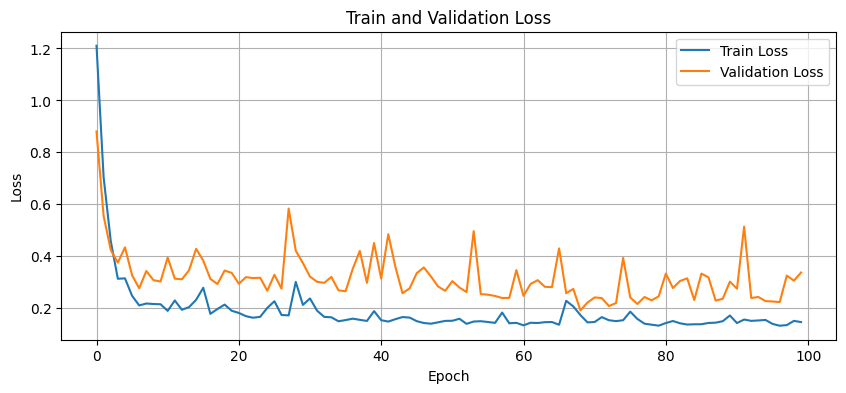

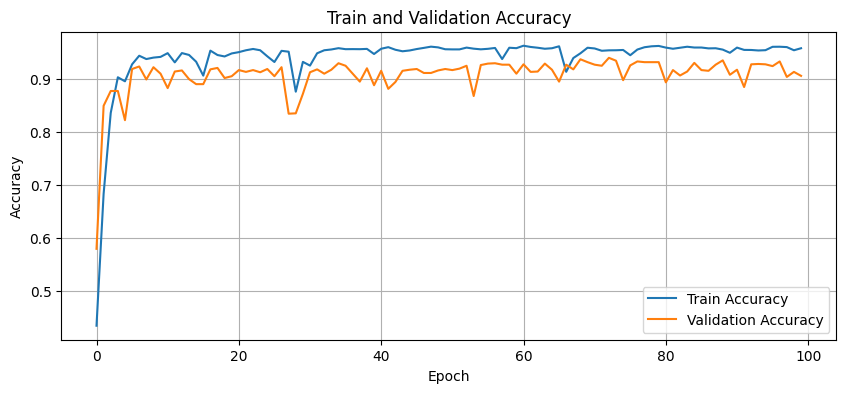

In [10]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

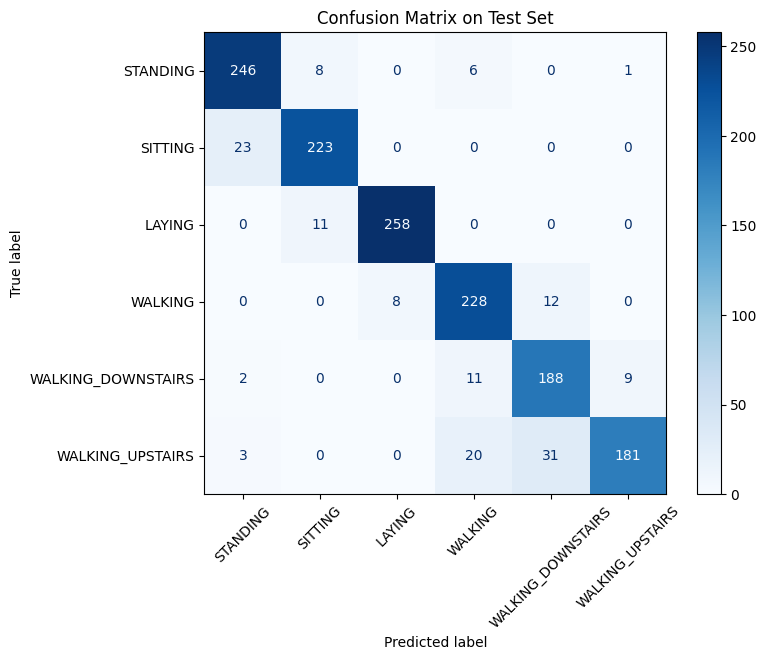

Accuracy on test set: 0.9013


In [11]:
# Get predictions on the validation (test) set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in final_test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activities)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

# Print accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Accuracy on test set: {accuracy:.4f}")